# MIT-BIH-AFIB-05-xfr-learn.ipynb
Experiment with transfer learning using datasets from the MIT-BIH Atrial Fibrillation Database.   
See https://physionet.org/content/afdb/1.0.0/  

In [1]:
# Environment setup.
import os
import re
import sys
import platform
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import fileutils as fu
import model_utils as mu
import mit_bih_afib_db as db
import mit_bih_afib_tfrecord as tfr

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

os_name = platform.system()
print('OS name:            {} {}'.format(os_name, platform.release()))
print('Python version:     {}.{}.{}'.format(sys.version_info[0], sys.version_info[1], sys.version_info[2]))
print('TensorFlow version: {}'.format(tf.__version__))
print('Numpy version:      {}'.format(np.__version__))
print('You are here: {}'.format(os.getcwd()))

OS name:            Windows 10
Python version:     3.10.10
TensorFlow version: 2.10.0
Numpy version:      1.23.2
You are here: D:\dev\jupyter\deep-cnn-embedded\src\mit-bih-afib


In [2]:
# Set the local data paths based on our environment.
if (os_name == 'Windows'):
    DATASET_PATH_ROOT = r'E:/Data/MIT-BIH-AFIB'
    db.LOCAL_TFRECORD_PATH = os.path.join(DATASET_PATH_ROOT, 'tfrecord')
else:
    DATASET_PATH_ROOT = os.getcwd()
    db.LOCAL_TFRECORD_PATH = os.path.join(DATASET_PATH_ROOT, 'tfrecord')

In [3]:
# ECG parameters.
tfr.ECG_LENGTH = 7500
tfr.ECG_FEATURE = 'ecg_fir_z'

LABELS = {'N':0, 'AFIB':1}         # Data labels
CLASS_NAMES = list(LABELS.keys())  # Class names in same order as labels
NUM_CLASSES = len(LABELS)

### Create train, test, and validation datasets from previously generated files  

In [4]:
train_file = os.path.join(db.LOCAL_TFRECORD_PATH, 'tfrecord_train_list.csv')
test_file = os.path.join(db.LOCAL_TFRECORD_PATH, 'tfrecord_test_list.csv')
val_file = os.path.join(db.LOCAL_TFRECORD_PATH, 'tfrecord_val_list.csv')
train_list, test_list, val_list = tfr.get_tfrecord_lists(train_file, test_file, val_file, path=DATASET_PATH_ROOT)
train_size = len(train_list)
test_size = len(test_list)
val_size = len(val_list)
print('Train size:      {}'.format(train_size))
print('Test size:       {}'.format(test_size))
print('Validation size: {}'.format(val_size))

Train size:      9956
Test size:       554
Validation size: 554


In [5]:
batch_size = 32
buffer_size = train_size // batch_size
val_step_size = val_size // batch_size
print('Training:   {} batches of {} = {} examples'.format(buffer_size, batch_size, buffer_size*batch_size))
print('Validation: {} batches of {} = {} examples'.format(val_step_size, batch_size, val_step_size*batch_size))

Training:   311 batches of 32 = 9952 examples
Validation: 17 batches of 32 = 544 examples


In [6]:
# Function to check the dataset one-hot output.
def check_one_hot(dataset):
    count = 0
    for ds in dataset:
        count += 1
        one_hot = ds[1]
        if (np.sum(one_hot) != 1.):
            print('Data set error at record {}'.format(count))
            break

In [7]:
check_dataset = True
train_ds = tf.data.TFRecordDataset(train_list)
train_ds = train_ds.map(tfr.ecg_map_2class)
if check_dataset:
    print('Checking training dataset')
    check_one_hot(train_ds)
train_ds = train_ds.shuffle(buffer_size)
train_ds = train_ds.batch(batch_size, drop_remainder=True)

test_ds = tf.data.TFRecordDataset(test_list)
test_ds = test_ds.map(tfr.ecg_map_2class)
if check_dataset:
    print('Checking test dataset')
    check_one_hot(test_ds)
test_ds = test_ds.batch(batch_size=1, drop_remainder=True)

val_ds = tf.data.TFRecordDataset(val_list)
val_ds = val_ds.map(tfr.ecg_map_2class)
if check_dataset:
    print('Checking validation dataset')
    check_one_hot(val_ds)
val_ds = val_ds.batch(batch_size, drop_remainder=True)

Checking training dataset
Checking test dataset
Checking validation dataset


### Load a previously trained model

In [8]:
model_dir = os.path.abspath('../Icentia11k/checkpoint/InceptionTimeNetV4-D05')
model_file = os.path.join(model_dir, 'InceptionTimeNetV4-D05.h5')
weights_file = os.path.join(model_dir, 'weights-it01-0033.h5')

In [9]:
# Load the model and its weights.
orig_model = mu.load_model(model_file)
mu.load_weights(orig_model, weights_file)
orig_model.summary(line_length=120)

Model: "InceptionTimeNetV4-D05"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 ecg_input (InputLayer)                [(None, 7500, 1)]          0             []                                      
                                                                                                                        
 Conv1_1 (Conv1D)                      (None, 7500, 32)           288           ['ecg_input[0][0]']                     
                                                                                                                        
 Conv2_1 (Conv1D)                      (None, 7500, 32)           544           ['ecg_input[0][0]']                     
                                                                                                                        


                                                                                                                        
 ReLU4_2 (ReLU)                        (None, 3750, 32)           0             ['BN4_2[0][0]']                         
                                                                                                                        
 MaxPool_2 (MaxPooling1D)              (None, 7500, 160)          0             ['Concat_1[0][0]']                      
                                                                                                                        
 Drop1_2 (Dropout)                     (None, 3750, 32)           0             ['ReLU1_2[0][0]']                       
                                                                                                                        
 Drop2_2 (Dropout)                     (None, 3750, 32)           0             ['ReLU2_2[0][0]']                       
                                

                                                                                                                        
 Conv3_4 (Conv1D)                      (None, 938, 32)            163872        ['Pad_4[0][0]']                         
                                                                                                                        
 Conv4_4 (Conv1D)                      (None, 938, 32)            327712        ['Pad_4[0][0]']                         
                                                                                                                        
 BN1_4 (BatchNormalization)            (None, 938, 32)            128           ['Conv1_4[0][0]']                       
                                                                                                                        
 BN2_4 (BatchNormalization)            (None, 938, 32)            128           ['Conv2_4[0][0]']                       
                                

                                                                                                                        
 Drop3_5 (Dropout)                     (None, 469, 32)            0             ['ReLU3_5[0][0]']                       
                                                                                                                        
 Drop4_5 (Dropout)                     (None, 469, 32)            0             ['ReLU4_5[0][0]']                       
                                                                                                                        
 Conv_skip_5 (Conv1D)                  (None, 469, 32)            5152          ['MaxPool_5[0][0]']                     
                                                                                                                        
 Concat_5 (Concatenate)                (None, 469, 160)           0             ['Drop1_5[0][0]',                       
                                

### Modify the model for transfer learning

In [10]:
# File paths and names.
model_name = orig_model.name + '-new'
checkpoint_dir = os.path.join(os.getcwd(), 'checkpoint', model_name)
model_file_base = os.path.join(checkpoint_dir, model_name)
fu.mkpath(checkpoint_dir)
print('Checkpoint directory: {}'.format(checkpoint_dir))

Checkpoint directory: D:\dev\jupyter\MIT-BIH-AFIB\checkpoint\InceptionTimeNetV4-D05-new


In [33]:
# Remove the last layer and replace it with a new layer.
model_out = orig_model.layers[-2].output
model_out = Dense(NUM_CLASSES, activation='softmax', name='FC_New')(model_out)
ecg_model = Model(orig_model.input, model_out, name=model_name)

# Make all layers non-trainable except for the fully connected layers at the end.
for l in ecg_model.layers:
    if (l.name.startswith('FC_')):
        l.trainable = True
    else:
        l.trainable = False
ecg_model.summary(show_trainable=True, line_length=100)

Model: "InceptionTimeNetV4-D05-new"
_______________________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     Trainable  
 ecg_input (InputLayer)          [(None, 7500, 1)]     0           []                               N          
                                                                                                               
 Conv1_1 (Conv1D)                (None, 7500, 32)      288         ['ecg_input[0][0]']              N          
                                                                                                               
 Conv2_1 (Conv1D)                (None, 7500, 32)      544         ['ecg_input[0][0]']              N          
                                                                                                               
 Conv3_1 (Conv1D)                (None, 7500, 32)      1056        [

 Drop1_2 (Dropout)               (None, 3750, 32)      0           ['ReLU1_2[0][0]']                N          
                                                                                                               
 Drop2_2 (Dropout)               (None, 3750, 32)      0           ['ReLU2_2[0][0]']                N          
                                                                                                               
 Drop3_2 (Dropout)               (None, 3750, 32)      0           ['ReLU3_2[0][0]']                N          
                                                                                                               
 Drop4_2 (Dropout)               (None, 3750, 32)      0           ['ReLU4_2[0][0]']                N          
                                                                                                               
 Conv_skip_2 (Conv1D)            (None, 3750, 32)      5152        ['MaxPool_2[0][0]']              N   

 BN4_4 (BatchNormalization)      (None, 938, 32)       128         ['Conv4_4[0][0]']                N          
                                                                                                               
 ReLU1_4 (ReLU)                  (None, 938, 32)       0           ['BN1_4[0][0]']                  N          
                                                                                                               
 ReLU2_4 (ReLU)                  (None, 938, 32)       0           ['BN2_4[0][0]']                  N          
                                                                                                               
 ReLU3_4 (ReLU)                  (None, 938, 32)       0           ['BN3_4[0][0]']                  N          
                                                                                                               
 ReLU4_4 (ReLU)                  (None, 938, 32)       0           ['BN4_4[0][0]']                  N   

                                                                                                               
 Drop_6 (Dropout)                (None, 128)           0           ['FC_6[0][0]']                   N          
                                                                                                               
 FC_7 (Dense)                    (None, 64)            8256        ['Drop_6[0][0]']                 Y          
                                                                                                               
 Drop_7 (Dropout)                (None, 64)            0           ['FC_7[0][0]']                   N          
                                                                                                               
 FC_8 (Dense)                    (None, 16)            1040        ['Drop_7[0][0]']                 Y          
                                                                                                        

### Compile the model

In [12]:
initial_lr = 1.0e-04  # Start with a small learning rate since model is pre-trained

opt = tf.keras.optimizers.Adam(
    learning_rate=initial_lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1.0e-08,
)

ecg_model.compile(
    optimizer=opt, 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Train the model

In [13]:
# Set up training callbacks.
train_history = None
monitor_label = 'val_accuracy'
monitor_mode  = 'max'
ckpt = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'weights-r03-{epoch:04d}.h5'),
    monitor=monitor_label, 
    mode=monitor_mode,
    save_best_only=True, 
    save_weights_only = True,
    verbose=1, 
)
esc = EarlyStopping(
    monitor=monitor_label,
    mode=monitor_mode,
    min_delta=0, 
    patience=7, 
    restore_best_weights=True,
    verbose=1,
)
rop = ReduceLROnPlateau(
    monitor=monitor_label,
    mode=monitor_mode,
    min_delta=0,
    factor=0.5,
    min_lr=1.0e-08,
    patience=2,
    cooldown=0,
    verbose=1, 
)

In [14]:
num_epochs = 50
train_model = True
if train_model:
    print('{} Training start.'.format(db.timestamp()))
    
    train_history = ecg_model.fit(
        x=train_ds, 
        validation_data=val_ds, 
        callbacks=[ckpt, rop, esc],
        epochs=num_epochs)
    
    print('{} Training complete.'.format(db.timestamp()))
else:
    print('Model not trained.')

2023-07-04 08:55:32 Training start.
Epoch 1/50
    311/Unknown - 644s 2s/step - loss: 0.4438 - accuracy: 0.8621
Epoch 1: val_accuracy improved from -inf to 0.97059, saving model to D:\dev\jupyter\MIT-BIH-AFIB\checkpoint\InceptionTimeNetV4-D05-new\weights-r03-0001.h5
311/311 [==============================] - 675s 2s/step - loss: 0.4438 - accuracy: 0.8621 - val_loss: 0.1052 - val_accuracy: 0.9706 - lr: 1.0000e-04
Epoch 2/50
311/311 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.9746
Epoch 2: val_accuracy improved from 0.97059 to 0.98713, saving model to D:\dev\jupyter\MIT-BIH-AFIB\checkpoint\InceptionTimeNetV4-D05-new\weights-r03-0002.h5
311/311 [==============================] - 675s 2s/step - loss: 0.0918 - accuracy: 0.9746 - val_loss: 0.0474 - val_accuracy: 0.9871 - lr: 1.0000e-04
Epoch 3/50
311/311 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9835
Epoch 3: val_accuracy did not improve from 0.98713
311/311 [=========================

### Save the model

In [15]:
save_model = True
if save_model:
    saved = mu.save_model(ecg_model, model_file_base)
    print('ECG model saved to {}'.format(model_file_base))
else:
    print('ECG model not saved')

INFO:tensorflow:Assets written to: D:\dev\jupyter\MIT-BIH-AFIB\checkpoint\InceptionTimeNetV4-D05-new\InceptionTimeNetV4-D05-new\assets


INFO:tensorflow:Assets written to: D:\dev\jupyter\MIT-BIH-AFIB\checkpoint\InceptionTimeNetV4-D05-new\InceptionTimeNetV4-D05-new\assets


ECG model saved to D:\dev\jupyter\MIT-BIH-AFIB\checkpoint\InceptionTimeNetV4-D05-new\InceptionTimeNetV4-D05-new


### Run predictions

In [16]:
# Create the ground truth targets array.
targets_list = []
for tds in test_ds:
    targets_list.append(tds[1])
targets = np.squeeze(np.asarray(targets_list), 1) # Convert dataset to array, remove unused dimension
print('Targets shape: {}'.format(targets.shape))

Targets shape: (554, 2)


In [17]:
# Perform predictions on the test dataset.
predictions = np.asarray(
    ecg_model.predict(
        x=test_ds,
        steps=None,
        verbose=1
    )
)
print('Predictions shape: {}'.format(predictions.shape))

554/554 [==============================] - 30s 54ms/step
Predictions shape: (554, 2)


In [18]:
# Create a classification array.
classifications = np.zeros(predictions.shape)
idx_array = np.argmax(predictions, axis=1)
for i in range(predictions.shape[0]):
    p = predictions[i]
    idx = idx_array[i]
    if (p[idx] > 0.5):
        classifications[i,idx] = 1

In [19]:
# Sanity check the first element.
print('Prediction:     {}'.format(predictions[0]))
print('Target:         {}'.format(targets[0]))
print('Classification: {}'.format(classifications[0]))

Prediction:     [9.9981409e-01 1.8597097e-04]
Target:         [1. 0.]
Classification: [1. 0.]


### Save the results

In [20]:
# Function to append current history to previous history
def append_history(h_current, h_new):
    for k in h_new:
        if k in h_current:
            h_current[k] += h_new[k]
        else:
            h_current[k] = h_new[k]
    return h_current

In [21]:
# Save the results.
save_results = True
pickle_file = model_file_base + '_results.pickle'

# Append training history.
total_history = None

if train_history is not None:
    if os.path.isfile(pickle_file):
        saved_results = mu.load_results(pickle_file)
        total_history = append_history(saved_results['history'], train_history.history)
    else:
        total_history = train_history.history  
    
if save_results:
    pickle_results = {
        #'params' : params,
        'max_epochs' : num_epochs,
        'class_names' : CLASS_NAMES,
        'targets' : targets,
        'predictions' : predictions,
        'classifications' : classifications,
        'history' : total_history
    }
    print(mu.save_results(pickle_results, pickle_file))
    print('Results saved to {}.'.format(pickle_file))
else:
    print('Results not saved.')

True
Results saved to D:\dev\jupyter\MIT-BIH-AFIB\checkpoint\InceptionTimeNetV4-D05-new\InceptionTimeNetV4-D05-new_results.pickle.


### Load previously saved results

In [22]:
load_previous = False
if load_previous:
    saved_results = mu.load_results(pickle_file)
    num_epochs = saved_results['max_epochs']
    targets = saved_results['targets']
    predictions = saved_results['predictions']
    classifications = saved_results['classifications']
    total_history = saved_results['history']
    print('Previous results loaded.')
else:
    print('Previous results not loaded.')

Previous results not loaded.


### Compute metrics

In [23]:
# Run a classification report.
report = classification_report(targets, classifications, target_names=CLASS_NAMES, zero_division=0)
print(report)

              precision    recall  f1-score   support

           N       0.99      0.99      0.99       277
        AFIB       0.99      0.99      0.99       277

   micro avg       0.99      0.99      0.99       554
   macro avg       0.99      0.99      0.99       554
weighted avg       0.99      0.99      0.99       554
 samples avg       0.99      0.99      0.99       554



In [24]:
# Additional metrics for each class.
for i in range(NUM_CLASSES):
    cm = confusion_matrix(targets[:,i], classifications[:,i])
    acc = (cm[0,0] + cm[1,1]) / np.sum(cm)
    ppv = cm[1,1] / (cm[1,1] + cm[0,1])
    fpr, tpr, _ = roc_curve(targets[:,i], classifications[:,i])
    roc_auc = auc(fpr, tpr)
    print('Confusion matrix for class {}:'.format(CLASS_NAMES[i]))
    print(cm)
    print('ACC: {:0.4f}'.format(acc))
    print('PPV: {:0.4f}'.format(ppv))
    print('AUC: {:0.4f}'.format(roc_auc))
    print()

no_class_counts = np.zeros(NUM_CLASSES)
num_examples = targets.shape[0]
for i in range(num_examples):
    if np.sum(classifications[i]) == 0:
        no_class_counts[np.argmax(targets[i])] += 1
no_class_sum = np.sum(no_class_counts)
no_class_pct = 100. * no_class_sum / num_examples
print('There are {} predictions with no classification ({:0.2f}%).'.format(int(no_class_sum), no_class_pct))
for i in range(NUM_CLASSES):
    print('True {:5s}: {}'.format(CLASS_NAMES[i], int(no_class_counts[i])))

Confusion matrix for class N:
[[274   3]
 [  2 275]]
ACC: 0.9910
PPV: 0.9892
AUC: 0.9910

Confusion matrix for class AFIB:
[[275   2]
 [  3 274]]
ACC: 0.9910
PPV: 0.9928
AUC: 0.9910

There are 0 predictions with no classification (0.00%).
True N    : 0
True AFIB : 0


### Plot training metrics

Total epochs: 18
Max val_accuracy at epoch 11: 0.9945


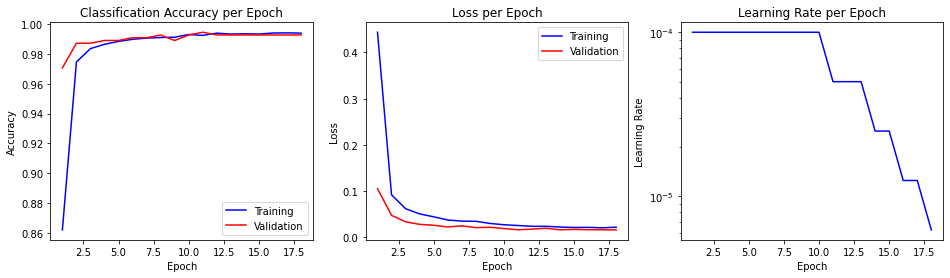

In [25]:
fig, (ax_acc, ax_mse, ax_lr) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
plt.yscale('linear')

total_epochs = len(total_history['loss'])
max_idx = np.argmax(total_history['val_accuracy'])
max_acc = total_history['val_accuracy'][max_idx]
print('Total epochs: {}'.format(total_epochs))
print('Max val_accuracy at epoch {}: {:0.4f}'.format(max_idx+1, max_acc))

ax_acc.plot(range(1, total_epochs+1), total_history['accuracy'], color='blue', label='Training')
ax_acc.plot(range(1, total_epochs+1), total_history['val_accuracy'], color='red', label='Validation')
ax_acc.set_xlabel('Epoch')
ax_acc.set_ylabel('Accuracy')
ax_acc.set_title('Classification Accuracy per Epoch')
ax_acc.legend()

ax_mse.plot(range(1, total_epochs+1), total_history['loss'], color='blue', label='Training')
ax_mse.plot(range(1, total_epochs+1), total_history['val_loss'], color='red', label='Validation')
ax_mse.set_xlabel('Epoch')
ax_mse.set_ylabel('Loss')
ax_mse.set_title('Loss per Epoch')
ax_mse.legend()

plt.yscale('log')
ax_lr.plot(range(1, total_epochs+1), total_history['lr'], color='blue')
ax_lr.set_xlabel('Epoch')
ax_lr.set_ylabel('Learning Rate')
ax_lr.set_title('Learning Rate per Epoch')

plt.show()

### Plot a confusion matrix

In [26]:
class my_formatter(matplotlib.ticker.Formatter):
    def __init__(self, x, pos):
        super(matplotlib.ticker.Formatter, self).__init__()
    def __call__(self, x, pos):
        return '{:0.2f}'.format(10.**x)

In [27]:
def plot_confusion_matrix(targets, classifications, class_names):
    num_examples = targets.shape[0]
    num_classes = targets.shape[1]
    
    # Count plot_confusion_matrixactual vs. classification instances.
    heatmap_data = np.zeros((num_classes, num_classes))
    for i in range(num_examples):
        x = np.argmax(classifications[i])
        y = np.argmax(targets[i])
        heatmap_data[x, (num_classes - y - 1)] += 1
    #print(heatmap_data)
    heatmap_pct = (heatmap_data * 100) / num_examples  # Convert to percent of total
    #print(heatmap_pct)
    heatmap_data = np.log10(heatmap_pct)  # Convert to log scale for plotting
    #print(heatmap_data)
    
    # Create the color plot.
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(heatmap_data.T, cmap='Blues') 
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(np.arange(num_classes)+0.5, labels=class_names,)
    ax.set_yticks(np.arange(num_classes)+0.5, labels=reversed(class_names))

    # Overlay values.
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            val = '{:0.2f}'.format(heatmap_pct[i, j])
            text = ax.text(i+0.5, j+0.5, val, ha='center', va='center')

    # Create a colorbar.
    tickpos = [0.05, 0.1, 0.3, 1, 3, 10, 30]
    ticklist = np.log10(tickpos)
    plt.colorbar(heatmap, label='classification %', format=my_formatter(x, pos=None), ticks=ticklist)
    plt.show()

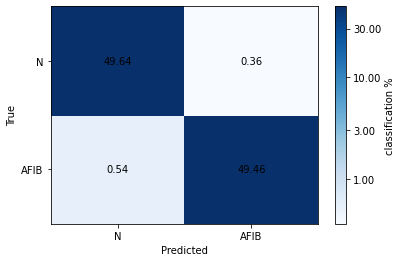

In [28]:
plot_confusion_matrix(targets, classifications, CLASS_NAMES)